In [221]:
from IPython.display import HTML, display,Image

In [87]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
from matplotlib import animation
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import pandas as pd
import matplotlib.gridspec as gridspec
import os.path
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import wget
from datetime import datetime,timedelta

xr.set_options(display_style="html")

import matplotlib.font_manager
matplotlib.font_manager._rebuild()

# Set common figure parameters
plt.style.use('seaborn-ticks')

newparams = { 'axes.grid': True,
             'lines.linewidth': 1.5, 'lines.linewidth': 2,
             'ytick.labelsize':15,
             'xtick.labelsize':15,
             'axes.labelsize':16,
             'axes.titlesize':16,
            'legend.fontsize':14,
             'figure.titlesize':16,
            'font.family':'Helvetica Light'}
#             'font.family':'DejaVu Sans'}
plt.rcParams.update(newparams)

In [187]:
def simpleaxis(ax):
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_top()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_label_position('top') 

In [185]:
def zoomed_ax(ax_padre,ax_hijo,location,limits_x,limits_y,color):
    ax=ax_padre.inset_axes(location, transform=ax_padre.transData)
    ax.set_facecolor((1, 1, 1,0))
    ax.set(xlim=limits_x,ylim=limits_y,xticklabels=[],yticklabels=[],xticks=[],yticks=[])
    ax_hijo.set(xlim=limits_x,ylim=limits_y,xticklabels=[],yticklabels=[],xticks=[],yticks=[])
    ax.invert_yaxis()
    ax.indicate_inset_zoom(ax_hijo, edgecolor=color)

    return ax_padre,ax_hijo,ax

In [89]:
data=xr.open_dataset('t0n156e_dy.cdf',decode_times=False)

In [90]:
data

<xarray.Dataset>
Dimensions:    (depth: 20, depzsst: 1, lat: 1, lon: 1, time: 10872)
Coordinates:
  * time       (time) float32 0.0 1.0 2.0 3.0 ... 1.087e+04 1.087e+04 1.087e+04
  * depth      (depth) float32 1.0 3.0 5.0 10.0 20.0 ... 300.0 400.0 500.0 750.0
  * lat        (lat) float32 0.0
  * lon        (lon) float32 156.0
  * depzsst    (depzsst) float32 1.0
Data variables:
    T_20       (time, depth, lat, lon) float32 ...
    QT_5020    (time, depth, lat, lon) float32 ...
    ST_6020    (time, depth, lat, lon) float32 ...
    ZSST_2003  (time, depzsst, lat, lon) float32 ...
Attributes:
    platform_code:                0n156e
    site_code:                    0n156e
    wmo_platform_code:            52317
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                12:29 17-DEC-2021

In [150]:
time=[datetime(1991,8,29,12,0,0)+timedelta(days=int(data.time[w])) for w in range (len(data.time))]  
dates=pd.DatetimeIndex(time)

In [93]:
colors = plt.cm.YlGn(np.linspace(0,1,len(data.time)))

In [94]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [95]:
depths_iso20=np.ones(data.depth.shape)
depths_iso20

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [96]:
data.depth

<xarray.DataArray 'depth' (depth: 20)>
array([  1.,   3.,   5.,  10.,  20.,  25.,  30.,  50.,  75., 100., 125., 150.,
       175., 200., 225., 250., 300., 400., 500., 750.], dtype=float32)
Coordinates:
  * depth    (depth) float32 1.0 3.0 5.0 10.0 20.0 ... 300.0 400.0 500.0 750.0
Attributes:
    FORTRAN_format:  
    units:           m
    type:            UNEVEN
    epic_code:       3
    positive:        down
    standard_name:   depth

In [117]:
sum(np.isnan(profile_t))

20

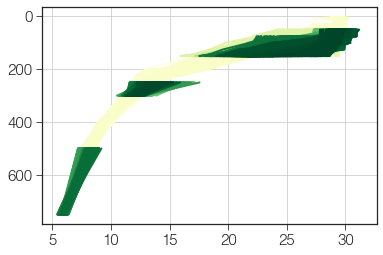

In [160]:
depths_iso20=[]
dates_iso20=[]
for date in range(0,len(data.time.values)):
    profile_t=data.T_20.values[date,:,0,0]
    idx_nan=np.argwhere(np.isnan(profile_t)).ravel()
    profile_t_wo_nans=np.delete(profile_t,idx_nan)
    depths_wo_nans=np.delete(data.depth.values,idx_nan)
    plt.plot(profile_t,data.depth.values,c=colors[date])
#     print(profile_t)
#     print(profile_t_wo_nans)
#     print(depths_wo_nans)
    if sum(np.isnan(profile_t))<16:
        solutions = InterpolatedUnivariateSpline(depths_wo_nans, profile_t_wo_nans - 20,k=3).roots()
#     print(solutions)

    if len(solutions)>0:
        depths_iso20.append(solutions[0])
        dates_iso20.append(time[date])
    

plt.gca().invert_yaxis()
# plt.xlim(19,21)
# plt.ylim(150,250)

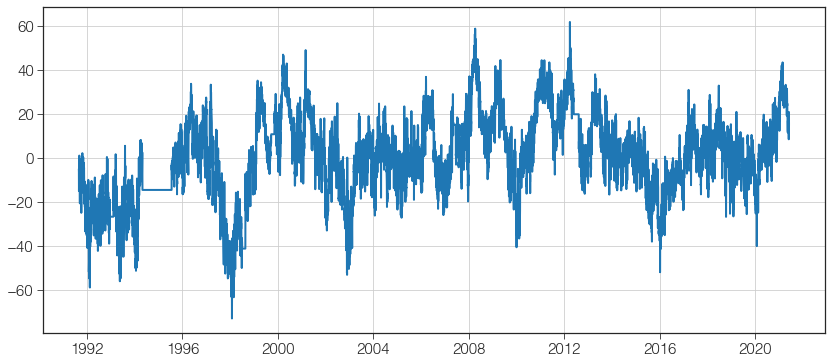

In [164]:
anm=depths_iso20-np.mean(depths_iso20)
plt.figure(figsize=(14,6))
plt.plot(dates_iso20,anm)

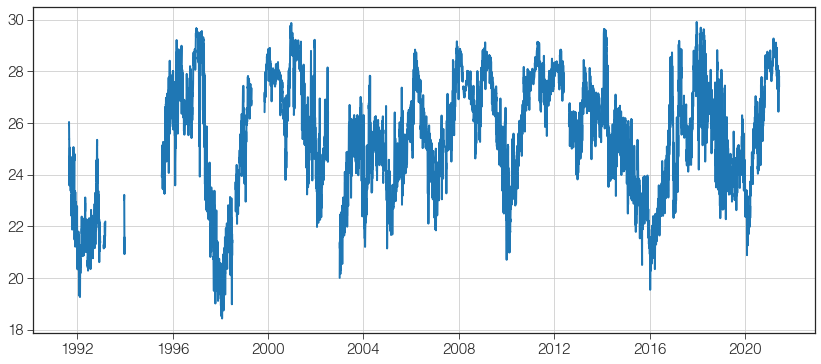

In [156]:
plt.figure(figsize=(14,6))
plt.plot(dates,data.T_20[:,10,0,0])

- Puede hacerse una animación con los aumentos y descensos de la termoclina en ese punto de interés
    - Fourier con más datos para analizar el período?
- Puede evaluarse los cambios en toda una seccion de profundidad

In [232]:
idx=np.where((dates==datetime(2018,1,1,12,0,0)) | (dates==datetime(2020,12,31,12,0,0)))[0]

In [233]:
T20_interes=data.T_20.values[idx[0]:idx[-1],:,0,0]

In [234]:
T20_interes.shape

(1095, 20)

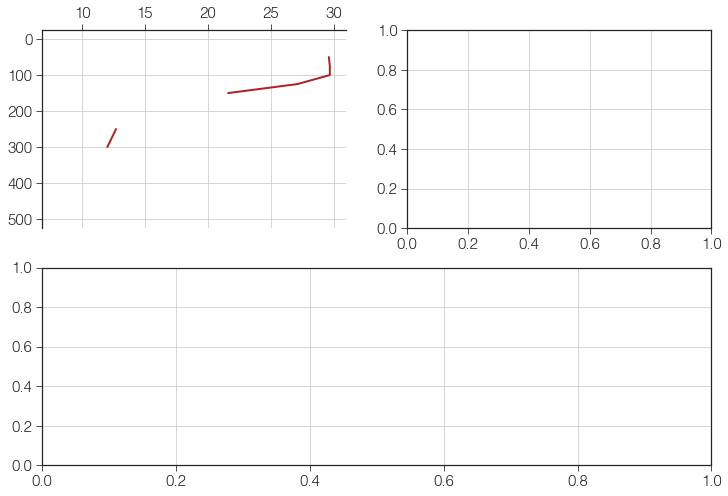

In [235]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

#define Matplotlib figure and axis

fig=plt.figure(figsize=(12,8))

gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])


# plt.subplots_adjust(wspace=0.05)

# # Main figure with profile
line1,=ax1.plot(T20_interes[0,:],data.depth.values,c='firebrick')
ax1.invert_yaxis()
# ax1.set_ylabel('Pressure (dbar)')
# ax1.set(xticklabels=[],xticks=[])

 # First zommed axes
location=[15, 200, 10, 100]
limits_x = (15,25)
limits_y = (200, 100)

# ax1,ax2,ax11=zoomed_ax(ax1,ax2,location,limits_x,limits_y,'skyblue')
# ax2.plot(profile_t,data.depth.values,c='firebrick')
# ax11.add_patch(patches.Rectangle((24, 283), 1, 33,facecolor='none',edgecolor='black'))
# ax11.axhline(y=300,linestyle='--',color='skyblue',lw=1)

simpleaxis(ax1)

# ax2.contourf(X,Y,rho_new_reshape.T,20,cmap='inferno_r')
# ax2.invert_yaxis()
# ax2.axhline(y=300,linestyle='--',color='skyblue',lw=2)
# ax2.add_patch(patches.Rectangle((24, 283), 2, 33,facecolor='none',edgecolor='black'))

# # Second zoomed axes
# location2=[20, 1500, 10, 100]
# limits_x2 = (20,30)
# limits_y2 = (1500, 1600)

# ax1,ax3,ax12=zoomed_ax(ax1,ax3,location2,limits_x2,limits_y2,'lightcoral')
# ax12.add_patch(patches.Rectangle((24, 1533), 1, 33,facecolor='none',edgecolor='white'))
# ax12.axhline(y=1550,linestyle='--',color='lightcoral',lw=1)

# ax3.contourf(X,Y,rho_new_reshape.T,20,cmap='inferno_r')
# ax3.invert_yaxis()
# ax3.axhline(y=1550,linestyle='--',color='lightcoral',lw=2)
# ax3.add_patch(patches.Rectangle((24, 1533), 2, 33,facecolor='none',edgecolor='white'))

# # Creating colorbar
# cax= fig.add_axes([ax3.get_position().x1+0.01,ax3.get_position().y0,0.01,ax1.get_position().height])
# cbar=plt.colorbar(cf,cax=cax,orientation="vertical",pad=0.15)
# cbar.set_label('Density-1000 kg/m$^{3}$',fontsize=16)
# cbar.ax.tick_params(labelsize=16)

# # set-up time series
# ax4.set(ylim=(-4,4),xlim=(0,1),ylabel='Amplitud[m]',xlabel='time[hours]')

# for axis in ['top','bottom','left','right']:
#     ax11.spines[axis].set_linewidth(2)
#     ax11.spines[axis].set_color('skyblue')

# for axis in ['top','bottom','left','right']:
#     ax12.spines[axis].set_linewidth(2)
#     ax12.spines[axis].set_color('lightcoral')
    
# recs1=[]
# recs2=[]
# vert_delta1=[]
# vert_delta2=[]
# t=[]
# line1,=ax4.plot(t,vert_delta1,color='skyblue')
# line2,=ax4.plot(t,vert_delta2,color='lightcoral')

def init():
    a=0
    return fig,ax1,ax2,ax3

# # # # Next we need to create a function that updates the values for the colormesh, as well as the title.

def animate(frame):
    if frame >0:
        line1.set_data(T20_interes[frame,:],data.depth)

    
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    init_func=init,
    frames=40,       # Could also be iterable or list
    interval=600    # ms between frames
)
# plt.close()

In [236]:
HTML(ani.to_jshtml())

In [165]:
def T_fourier(serie):
    fourier=np.fft.fft(serie)
    freq= np.fft.fftfreq(len(serie)) 
    pot = np.abs(fourier*1/len(serie))**2
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

In [170]:
nmm_fourier,nmm_freq_pos,nmm_potencias,nmm_periodos,nmm_freq=T_fourier(anm)

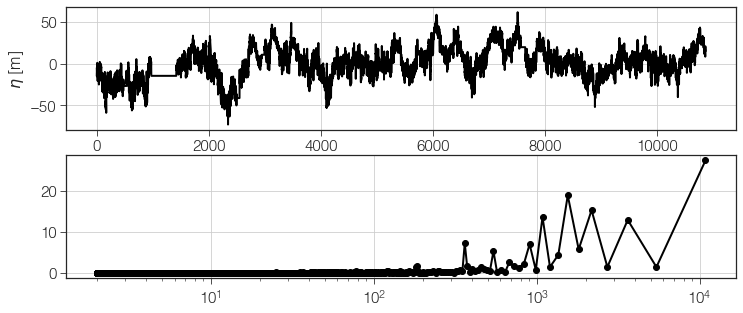

In [171]:
fig,[ax,ax2]=plt.subplots(2,1,figsize=(12,5))

ax.plot(anm,c='k')
ax.set_ylabel("$\eta$ [m]")
ax.set_xlabel("Tiempo [meses]")

ax2.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="k")
ax2.set_xscale("log")

(0.0, 3.0)

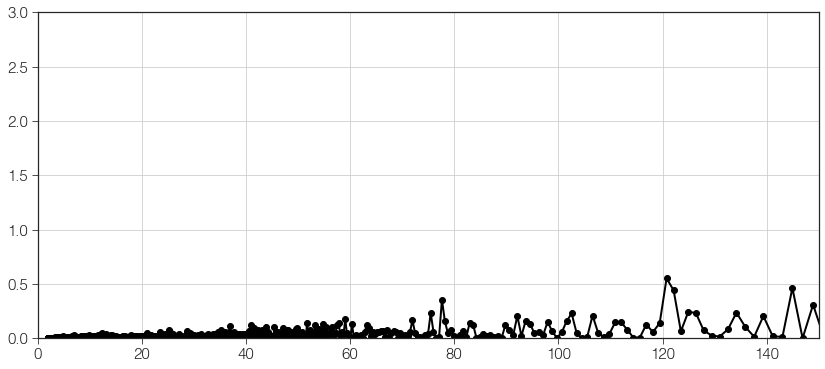

In [177]:
plt.figure(figsize=(14,6))
plt.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="k")
plt.xlim(0,150)
plt.ylim(0,3)

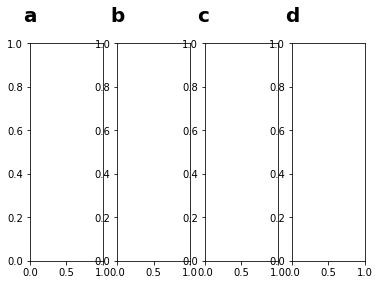

In [1]:
import string
from matplotlib.axes import Axes
from matplotlib import rcParams
import matplotlib.pyplot as plt


def index_subplots(
    axs: Axes,
    font_size: float = 20,
    font_weight: str = "bold",
    font_family: str = rcParams["font.family"],
    x: float = -0.1,
    y: float = 1.1,
    uppercase: bool = False,
    prefix: str = "",
    suffix: str = "",
    offset: int = 0,
):
    int_to_char_map = string.ascii_lowercase
    if uppercase:
        int_to_char_map = string.ascii_uppercase

    for i, ax in enumerate(axs):
        ax.text(
            x,
            y,
            prefix + int_to_char_map[i + offset] + suffix,
            transform=ax.transAxes,
            size=font_size,
            weight=font_weight,
            fontfamily=font_family,
        )

fig,[ax1,ax2,ax3,ax4]=plt.subplots(1,4)
index_subplots([ax1,ax2,ax3,ax4])